In [ ]:
import scipy.io as sio
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("dark")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation, find_permutation

In [ ]:
def format_data(input):
    datas = []
    for i in range(input.shape[0]):
        input_cur = np.squeeze(input[i,:,:])

        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(input_cur, dtype=int))
    return datas

mat = sio.loadmat('rawdata.mat', squeeze_me=True, variable_names={'spdata','inpdata'})
data_sp = format_data(mat['spdata'])
data_inp = format_data(mat['inpdata'])

binsize = 0.01
n_trials = mat['spdata'].shape[0]
n_timebins = mat['spdata'].shape[1]
n_neurons = mat['spdata'].shape[2]

inp_dim = mat['inpdata'].shape[2]
state_dim = 10
disc_dim = 3

In [ ]:
fit_lds = ssm.LDS(n_neurons, state_dim, 
                   M = inp_dim,
                   transitions="sticky",
                   emissions="poisson_orthog", 
                   emission_kwargs=dict(link="softplus", bin_size=binsize))

# fit_lds = ssm.SLDS(n_neurons, disc_dim, state_dim, 
#                    M = inp_dim,
#                    transitions="sticky",
#                    emissions="poisson_orthog", 
#                    emission_kwargs=dict(link="softplus", bin_size=binsize))

fit_lds.initialize(data_sp)

elbos, q = fit_lds.fit(data_sp, inputs = data_inp, 
                       method="laplace_em",
                       variational_posterior="structured_meanfield",
                       initialize=False,
                       num_iters=10)

In [ ]:
# Plot the ELBOs
plt.plot(elbos[0:10], label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

In [ ]:
plt.figure()
plt.imshow(fit_lds.emissions.Cs[0,:,:],aspect='auto')
plt.colorbar()

In [ ]:
tr = 10

# Get the posterior mean of the continuous states
q_x = q.mean_continuous_states[tr]

# Smooth the data under the variational posterior
yhat = fit_lds.smooth(q_x, data_sp[tr], input=data_inp[tr])
zhat = fit_lds.most_likely_states(q_x, data_sp[tr], input=data_inp[tr])

plt.figure(figsize=(8,4))
for d in range(state_dim):
    plt.plot(yhat[:,d], '-', color=colors[d], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
# plt.legend(loc='upper right')
plt.title("Estimated States")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(zhat, '-', color=colors[d], label="Estimated States" if d==0 else None)
plt.ylabel("$x$")
plt.xlabel("time")
# plt.legend(loc='upper right')
plt.title("Estimated States")
plt.show()


plt.figure(figsize=(8,4))
plt.plot(yhat[0,:], yhat[1,:])
plt.ylabel("$x0$")
plt.xlabel("$x1$")
# plt.legend(loc='upper right')
plt.title("Estimated States")
plt.show()


In [ ]:
z_sim, x_sim, y_sim = fit_lds.sample(n_timebins, data_inp[tr])

In [ ]:
plt.figure()
plt.imshow(y_sim.T,aspect='auto',vmax = 1)
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(data_sp[tr].T, aspect='auto',vmax =1)
plt.colorbar()

In [ ]:
cnum = 45
plt.figure()
plt.plot(y_sim[:,cnum])
plt.plot(data_sp[tr][:,cnum])

# New attempts

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

import sys
sys.path.append(r"/Users/dikshagupta/python_transfer/pbups_phys/")
from phys_helpers import *
from physdata_preprocessing import *

from scipy.ndimage import gaussian_filter1d


In [64]:
p = dict()

p['ratname'] = "X046"
p['filenum'] = 0

p['region'] = 'DMS'
p['fr_thresh'] = 1.

p['align_to'] = 'cpoke_in'
p['post_mask'] = None
p['window'] = [0, 1500]
p['split_by'] = None
p['filter_type'] = None
p['filter_w'] = None
p['binsize'] = 25

p['K'] = 3   # number of discrete states
p['D'] = 5   # number of latent dimensions

In [65]:
def format_spikes(FR, ntrials):
    datas = []
    for i in range(ntrials):
        spikes_cur = np.squeeze(FR[:,:,i])

        # remove columns which contain NaNs
        idx_keep = np.invert(np.any(np.isnan(spikes_cur), axis=0))
        spikes_cur = spikes_cur[:,idx_keep]

        # Transpose the data for passing to SSM fit function
        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(spikes_cur.T, dtype=int))
    return datas

In [66]:
# load data and plot data:
# we need spiking data and trial info: lets start with cpoke in, stim start, clicks, and model activity until stimulus end
# need to get data from my repo

# lets get neural activity first
files = get_sortCells_for_rat(p['ratname'])
df_trial, df_cell, _ = load_phys_data_from_Cell(files[p['filenum']])
ntrials = len(df_trial)

# process df_cell
df_cell = df_cell[df_cell['stim_fr'] >= p['fr_thresh']].reset_index()
df_cell = df_cell[df_cell['region'].str.match(p['region'])].reset_index(drop = True)


# get rasters for each neuron and concatenate
y = []
for cellnum in range(len(df_cell)):
    PSTH = make_psth(df_cell.loc[cellnum, 'spiketime_s'], 
                        df_trial,
                        split_by = p['split_by'],
                        align_to = p['align_to'], 
                        post_mask = p['post_mask'],
                        window = p['window'], 
                        filter_type = p['filter_type'],
                        filter_w = p['filter_w'],
                        binsize = p['binsize'],
                        plot = False)

    y.append(PSTH['trial_fr'][0].T)
y = format_spikes(np.array(y), ntrials)









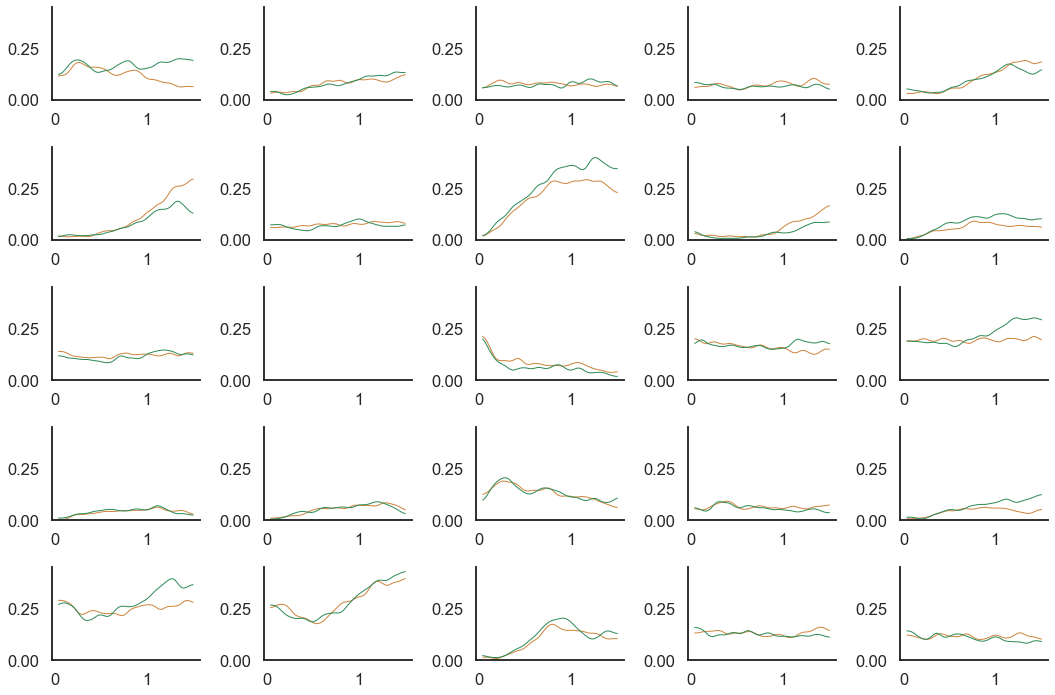

In [77]:
choice = split_trials(df_trial, 'pokedR')
y_left = np.mean(np.array(y)[choice[0]], axis = 0)
y_right = np.mean(np.array(y)[choice[1]], axis = 0)
fig, axs = plt.subplots(5, int(N/5), figsize = (15, int(N/5)*2))

for i, ax in enumerate(axs.ravel()):
    ax.plot(edges[1:] + p['binsize']/2000, gaussian_filter1d(y_left[:,i]/(p['binsize']*0.001), 2), c = 'peru', lw = 1)
    ax.plot(edges[1:] + p['binsize']/2000, gaussian_filter1d(y_right[:,i]/(p['binsize']*0.001), 2), c = 'seagreen', lw = 1)
    ax.set_ylim((0, 0.45))
    
fig.tight_layout()
sns.despine()

In [67]:
# Set the parameters of the SLDS
T = y[0].shape[0]    # number of time bins
K = p['K']    # number of discrete states
D = p['D']       # number of latent dimensions
N = len(df_cell)     # number of observed dimensions
M = inputs[0].shape[1]

Fitting SLDS with Laplace-EM


  0%|          | 0/5 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

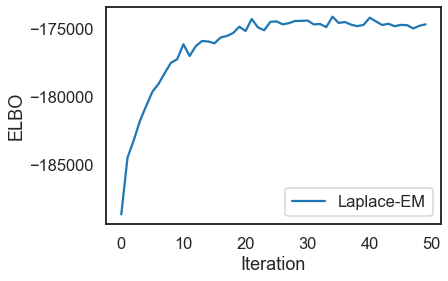

In [95]:
print("Fitting SLDS with Laplace-EM")
slds = ssm.SLDS(N, K, D, M = M, 
                emissions="poisson_orthog", 
#                 emission_kwargs=dict(link="log")
                emission_kwargs={"bin_size":p['binsize']/1000, "link":"log"})

slds.initialize(y, inputs = inputs)

q_lem_elbos, q_lem = slds.fit(y, inputs = inputs, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=50, 
                              initialize=True,
                              num_init_restarts = 5,
                              alpha=0.5)


plt.plot(q_lem_elbos[1:], label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

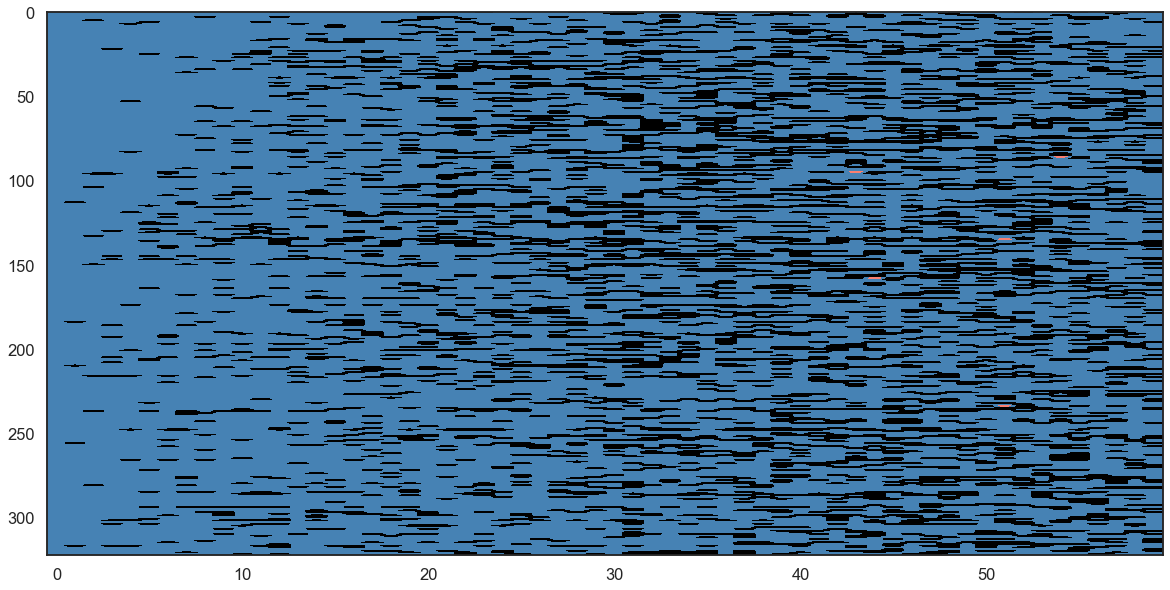

In [96]:
z = []
for tr in range(ntrials):
    q_lem_x = q_lem.mean_continuous_states[tr]
    q_lem_z = slds.most_likely_states(q_lem_x, y[tr], input = inputs[tr])
    z.append(q_lem_z)
    
# need to figure out how different trials are represented again


# Color for False and True
cmap = matplotlib.colors.ListedColormap(['salmon', 'steelblue', 'black'])

plt.figure(figsize = (20,10))
plt.imshow(z, aspect="auto", cmap = cmap)




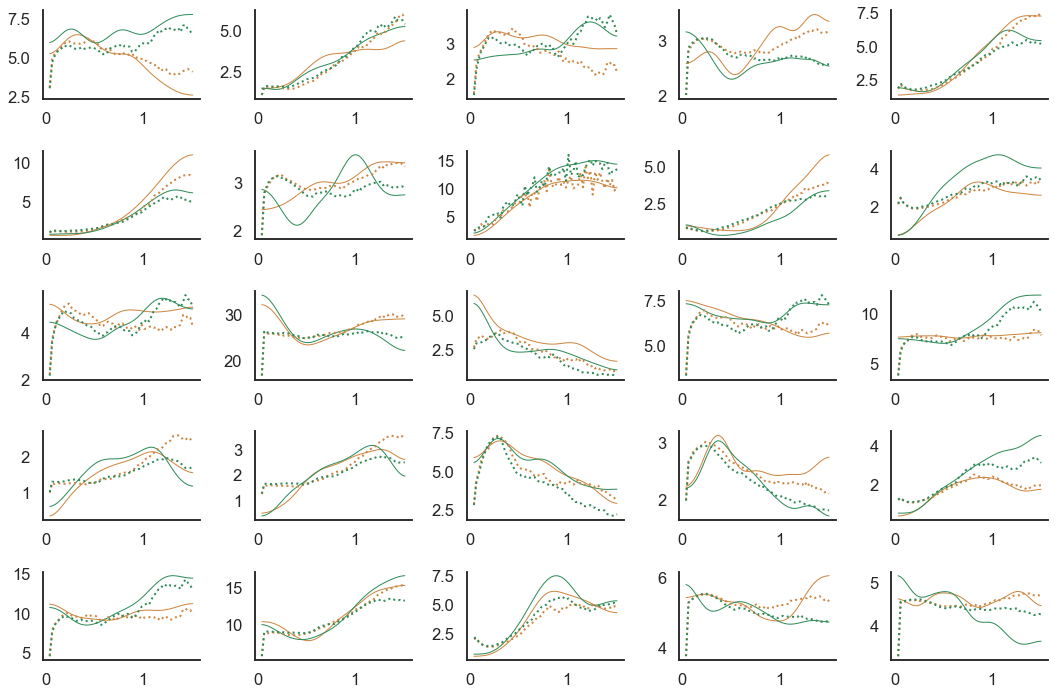

In [101]:
act = []
for tr in range(ntrials):
    q_lem_x = q_lem.mean_continuous_states[tr]
    # Smooth the data under the variational posterior
    q_lem_y = slds.smooth(q_lem_x, y[tr], input = inputs[tr])
    act.append(q_lem_y)
    
mean_y = np.mean(y, axis = 0)
mean_act = np.mean(act, axis = 0)

choice = split_trials(df_trial, 'pokedR')
y_left = np.mean(np.array(y)[choice[0]], axis = 0)
y_right = np.mean(np.array(y)[choice[1]], axis = 0)
fit_left = np.mean(np.array(act)[choice[0]], axis = 0)
fit_right = np.mean(np.array(act)[choice[1]], axis = 0)


from scipy.ndimage import gaussian_filter1d

fig, axs = plt.subplots(5, int(N/5), figsize = (15, int(N/5)*2))

for i, ax in enumerate(axs.ravel()):
    ax.plot(edges[1:] + p['binsize']/2000, gaussian_filter1d(y_left[:,i], 5)/(p['binsize'] * 0.001), c = 'peru', lw = 1)
    ax.plot(edges[1:] + p['binsize']/2000, gaussian_filter1d(y_right[:,i], 5)/(p['binsize'] * 0.001), c = 'seagreen', lw = 1)
    ax.plot(edges[1:] + p['binsize']/2000, fit_left[:,i]/(p['binsize'] * 0.001), ls = ':', c = 'peru', lw = 2)
    ax.plot(edges[1:] + p['binsize']/2000, fit_right[:,i]/(p['binsize'] * 0.001), ls = ':', c = 'seagreen', lw = 2)
#     ax.set_ylim((0, 0.45))
    
fig.tight_layout()
sns.despine()

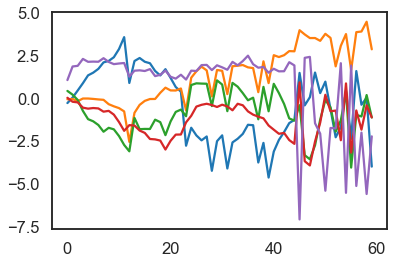

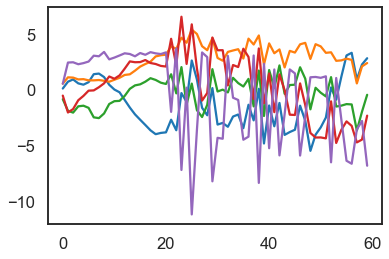

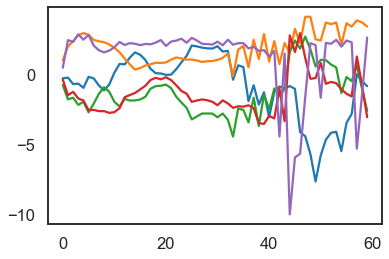

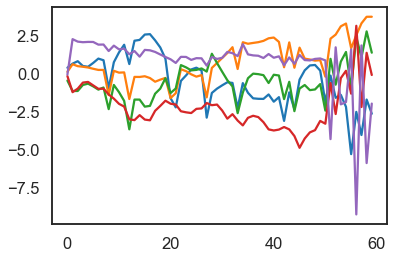

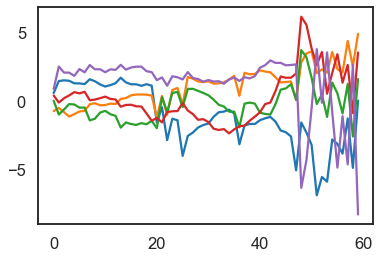

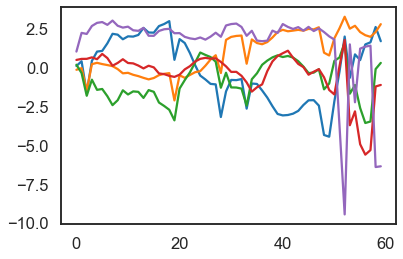

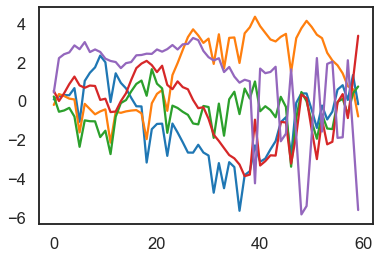

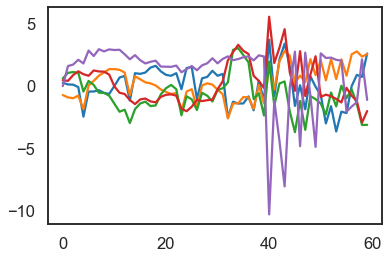

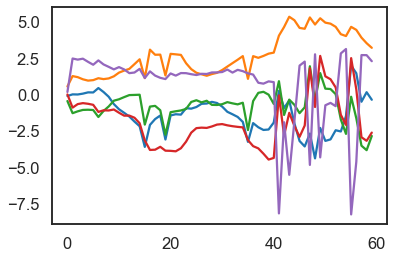

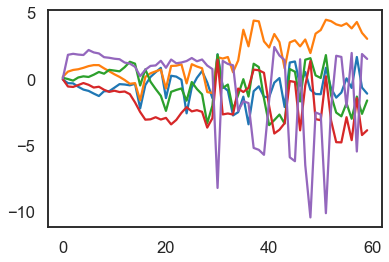

In [98]:
act = []
for tr in range(10):
    q_lem_x = q_lem.mean_continuous_states[tr]
    plt.figure()
    plt.plot(q_lem_x)

In [85]:
def save_object(obj, filename):
    import pickle
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# sample usage
save_object(q_lem, '/Users/dikshagupta/ondrive/analysisDG/PBups_Phys/saved_results/ssm_singlearea/test.pkl')

In [86]:
del q_lem

In [88]:
with open('/Users/dikshagupta/ondrive/analysisDG/PBups_Phys/saved_results/ssm_singlearea/test.pkl', 'rb') as input:
    import pickle
    q_lem = pickle.load(input)

In [89]:
q_lem

In [ ]:
# compute R^2
# use 10ms time bins
def compute_r2(true_psths, sim_psths):

    # get number of neurons
    assert len(true_psths) == len(sim_psths)
    N = len(true_psths)

    r2 = np.zeros(N)

    for i in range(N):

        true_psth = true_psths[i]
        sim_psth = sim_psths[i]
        true_psth_mean = [true_psth[coh] for coh in range(len(true_psth)) if true_psth[coh].shape[0] > 0]
        mean_PSTH = np.nanmean(np.vstack(true_psth_mean))

        r2_num = 0.0
        r2_den = 0.0

        # number of coherences, loop over
        NC = len(true_psth)
        for j in range(NC):
            T = true_psth[j].shape[0]
            if T > 0:
                r2_num += np.nansum( (true_psth[j] - sim_psth[j][:T])**2)
                r2_den += np.nansum( (mean_PSTH - true_psth[j])**2)

        r2[i] = 1 - r2_num / r2_den

    return r2

In [109]:
np.shape(y)

(323, 60, 28)

In [124]:


for train, test in kf.split(range(np.shape(y)[0])):
#     print("%s %s" % (train, test))
    y_train = [y[train_id] for train_id in train]
    print(np.shape(y_train))

(290, 60, 28)
(290, 60, 28)
(290, 60, 28)
(291, 60, 28)
(291, 60, 28)
(291, 60, 28)
(291, 60, 28)
(291, 60, 28)
(291, 60, 28)
(291, 60, 28)


In [129]:
len(y_train)

291

In [132]:
train

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [136]:
choice

{0: array([  0,   1,   2,   4,   6,   8,   9,  14,  19,  20,  21,  22,  28,
         29,  32,  34,  35,  36,  37,  40,  45,  46,  50,  51,  53,  57,
         58,  62,  64,  66,  67,  71,  72,  73,  74,  76,  80,  83,  84,
         90,  92,  96,  99, 101, 103, 108, 111, 112, 114, 115, 117, 121,
        126, 128, 130, 131, 132, 133, 134, 136, 143, 144, 145, 151, 152,
        155, 156, 160, 161, 163, 165, 167, 169, 171, 172, 174, 176, 177,
        178, 180, 183, 185, 187, 189, 190, 191, 194, 195, 196, 198, 199,
        200, 203, 204, 205, 208, 209, 210, 211, 214, 215, 216, 218, 219,
        223, 224, 226, 227, 230, 234, 235, 239, 240, 242, 243, 245, 246,
        250, 251, 253, 254, 256, 258, 260, 261, 262, 264, 265, 267, 271,
        272, 273, 274, 275, 277, 279, 280, 282, 286, 288, 290, 291, 292,
        293, 294, 298, 299, 300, 301, 303, 305, 306, 307, 309, 311, 314,
        316, 317, 319]),
 1: array([  3,   5,   7,  10,  11,  12,  13,  15,  16,  17,  18,  23,  24,
         25,  26,  2